## Python-пакеты для курса

[NumPy](https://numpy.org/): работа с массивами и матрицами

[Pandas](https://pandas.pydata.org/): обработка наборов данных

[Matplotlib](https://matplotlib.org/): визуализация данных

[SciPy](https://www.scipy.org/): вспомогательные функции

Все указанные инструменты собраны в пакете [Anaconda](https://docs.anaconda.com/anaconda/install/) — можно ограничиться его установкой

In [1]:
#importing and aliasing packages
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt

In [2]:
# creating parameter structures
class Parameters(object):
    pass

param = Parameters()
param.mu = 3.986e14
param.re = 6371e3
param.alt = 400e3
param.incl = 52 * np.pi / 180

sim_param = Parameters()
sim_param.t_0 = 0
sim_param.t_f = 2 * np.pi / np.sqrt(param.mu / ((param.re + param.alt) ** 3))
sim_param.dt = 1

In [3]:
#printing parameter values
print(param.mu, param.re, param.alt)
print(sim_param.t_0, sim_param.t_f, sim_param.dt)

398600000000000.0 6371000.0 400000.0
0 5544.858168881323 1


In the example to follow we are going to integrate a differential equation for a material point orbiting the Earth in a central gravity field:

$$
m \ddot{\mathbf{r}} = -\frac{\mu \cdot m \cdot \mathbf{r}}{|r|^3}
$$

Before actually integrating it we need to rewrite it in such a form that only the first derivatives over time remain in the left-hand side:

$$
\dot{\mathbf{r}} = \mathbf{v} \\
\dot{\mathbf{v}} = -\frac{\mu \cdot \mathbf{r}}{|r|^3}
$$

### Integration routine requires us to implement a function which computes the right-hand side of the equation for the integrator. This is done in the next cell.

In [4]:
def rhs(t, x, p):
    r = np.array(x[0:3])
    v = np.array(x[3:])
    
    dxdt = np.zeros(6)
    dxdt[0:3] = v
    dxdt[3:] = -p.mu * r / np.linalg.norm(r) ** 3
    
    return dxdt

### The following cell shows the call to the ode integrator (solve_ivp)

In [5]:
# initial conditions for the ode
v = np.sqrt(param.mu / (param.re + param.alt))
x_0 = [param.re + param.alt, 0, 0, \
       0, v * np.cos(param.incl), v * np.sin(param.incl)]

#array of time points, in which the solution will be evaluated
t_sol = np.arange(sim_param.t_0, sim_param.t_f, sim_param.dt)

#call of the integrator solve_ivp
sol = sci.solve_ivp(lambda t, x: rhs(t, x, param), \
                    (sim_param.t_0, sim_param.t_f), x_0, t_eval = t_sol,\
                    rtol=1e-10, atol=1e-10)

# array containing position and velocity components
x_sol = sol.y.T

### An example of a function to plot the integration results

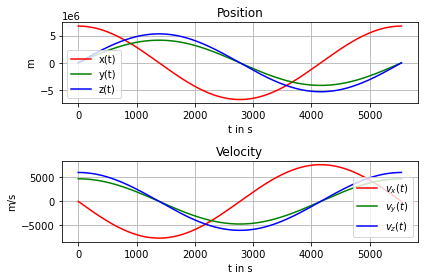

In [6]:
# plotting the position and velocity components
fig1, (ax1, ax2) = plt.subplots(2)

ax1.plot(t_sol, x_sol[:, 0], label = 'x(t)', color = 'r')
ax1.plot(t_sol, x_sol[:, 1], label = 'y(t)', color = 'g')
ax1.plot(t_sol, x_sol[:, 2], label = 'z(t)', color = 'b')

ax2.plot(t_sol, x_sol[:, 3], label = '$v_x(t)$', color = 'r')
ax2.plot(t_sol, x_sol[:, 4], label = '$v_y(t)$', color = 'g')
ax2.plot(t_sol, x_sol[:, 5], label = '$v_z(t)$', color = 'b')

ax1.grid(True)
ax2.grid(True)

ax1.legend()
ax2.legend()

ax1.set_title('Position')
ax1.set_ylabel(r'm')
ax1.set_xlabel(r't in s')
ax2.set_title('Velocity')
ax2.set_ylabel(r'm/s')
ax2.set_xlabel(r't in s')

plt.tight_layout()

### And a 3D plot

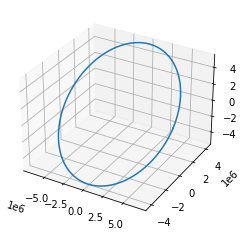

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_sol[:,0], x_sol[:,1], x_sol[:,2], label='parametric curve')

## Exercises

1. Play with differrent settings of solve_ivp. See what happens to the solution if you change tolerances (rtol and atol)


2. Play with different settings of plotting functions (legends, grids, colors, labels, etc.)


3. Implement Hohman transfer (transfer the satellite to an orbit with a greater altitude). This may require learning how to use events with solve_ivp


4. Write (or find) a function to convert the solution in Cartesian coordinates to Keplerian orbital elements


5. Add J2 effect to the differential equation. See how the solution changes. See what happens to the orbital elements (observe the drift in the RAAN and AoP, see what happens to the semimajor axis). How does this change the idea of the Hohman transfer?


## Symbolic Lagrange Equations with SymPy

In [8]:
from sympy import Symbol, symbols, Function, Eq
from sympy.calculus.euler import euler_equations
from sympy.printing.latex import LatexPrinter, print_latex

from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')

### defining symbols and deriving equations

In [9]:
m, k, t, u = symbols('m, k, t, u')
x, v = symbols('x, v', cls = Function)

# кинетическая энергия
T = Function('T')
T = 0.5 * m * x(t).diff(t)**2

# потенциальная эрергия
U = Function('U')
U = 0.5 * k * x(t)**2

# лагранжиан
L = T - U

# левая часть уравнений Лагранжа
osc_eqw = euler_equations(L, x(t), t)

# принт
print("Уравнения Лагранжа:")
display(osc_eqw[0])

Уравнения Лагранжа:


              2          
             d           
-k⋅x(t) - m⋅───(x(t)) = 0
              2          
            dt           

In [10]:
from sympy import dsolve

eqw = osc_eqw[0].subs([(m, 1), (k, 1)])

# начальные условия
initial_conditions = {x(0): 1, x(t).diff(t).subs(t, 0): 1}

# вызов солвера
sol = dsolve(eqw, x(t), ics=initial_conditions)

# принт
display(sol)
display(Eq(v(t), sol.rhs.diff(t)))

x(t) = 1.0⋅sin(1.0⋅t) + 1.0⋅cos(1.0⋅t)

v(t) = -sin(1.0⋅t) + 1.0⋅cos(1.0⋅t)

## Plotting

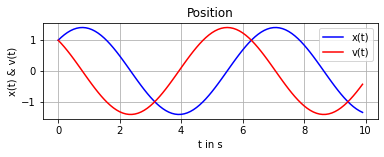

In [11]:
from sympy import lambdify, plot

pos_func = lambdify(t, sol.rhs, 'numpy')
vel_func = lambdify(t, sol.rhs.diff(t), 'numpy')

tvals = np.arange(0,10,.1)
xvals = pos_func(tvals)
vvals = vel_func(tvals)

fig, ax = plt.subplots(1,1,subplot_kw=dict(aspect='equal'))     
ax.plot(tvals, xvals, label = 'x(t)', color = 'b')
ax.plot(tvals, vvals, label = 'v(t)', color = 'r')

ax.grid(True)
ax.legend()

ax.set_title('Position')
ax.set_ylabel('x(t) & v(t)')
ax.set_xlabel(r't in s')

plt.show()